In [1]:
from pymongo import MongoClient
import pandas as pd
import datetime as dt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from adtk.data import validate_series
from adtk.visualization import plot
from adtk.detector import SeasonalAD
from adtk.data import to_events
from sklearn.cluster import KMeans
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D  
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import os 
import tempfile
import sklearn
from sklearn.metrics import confusion_matrix


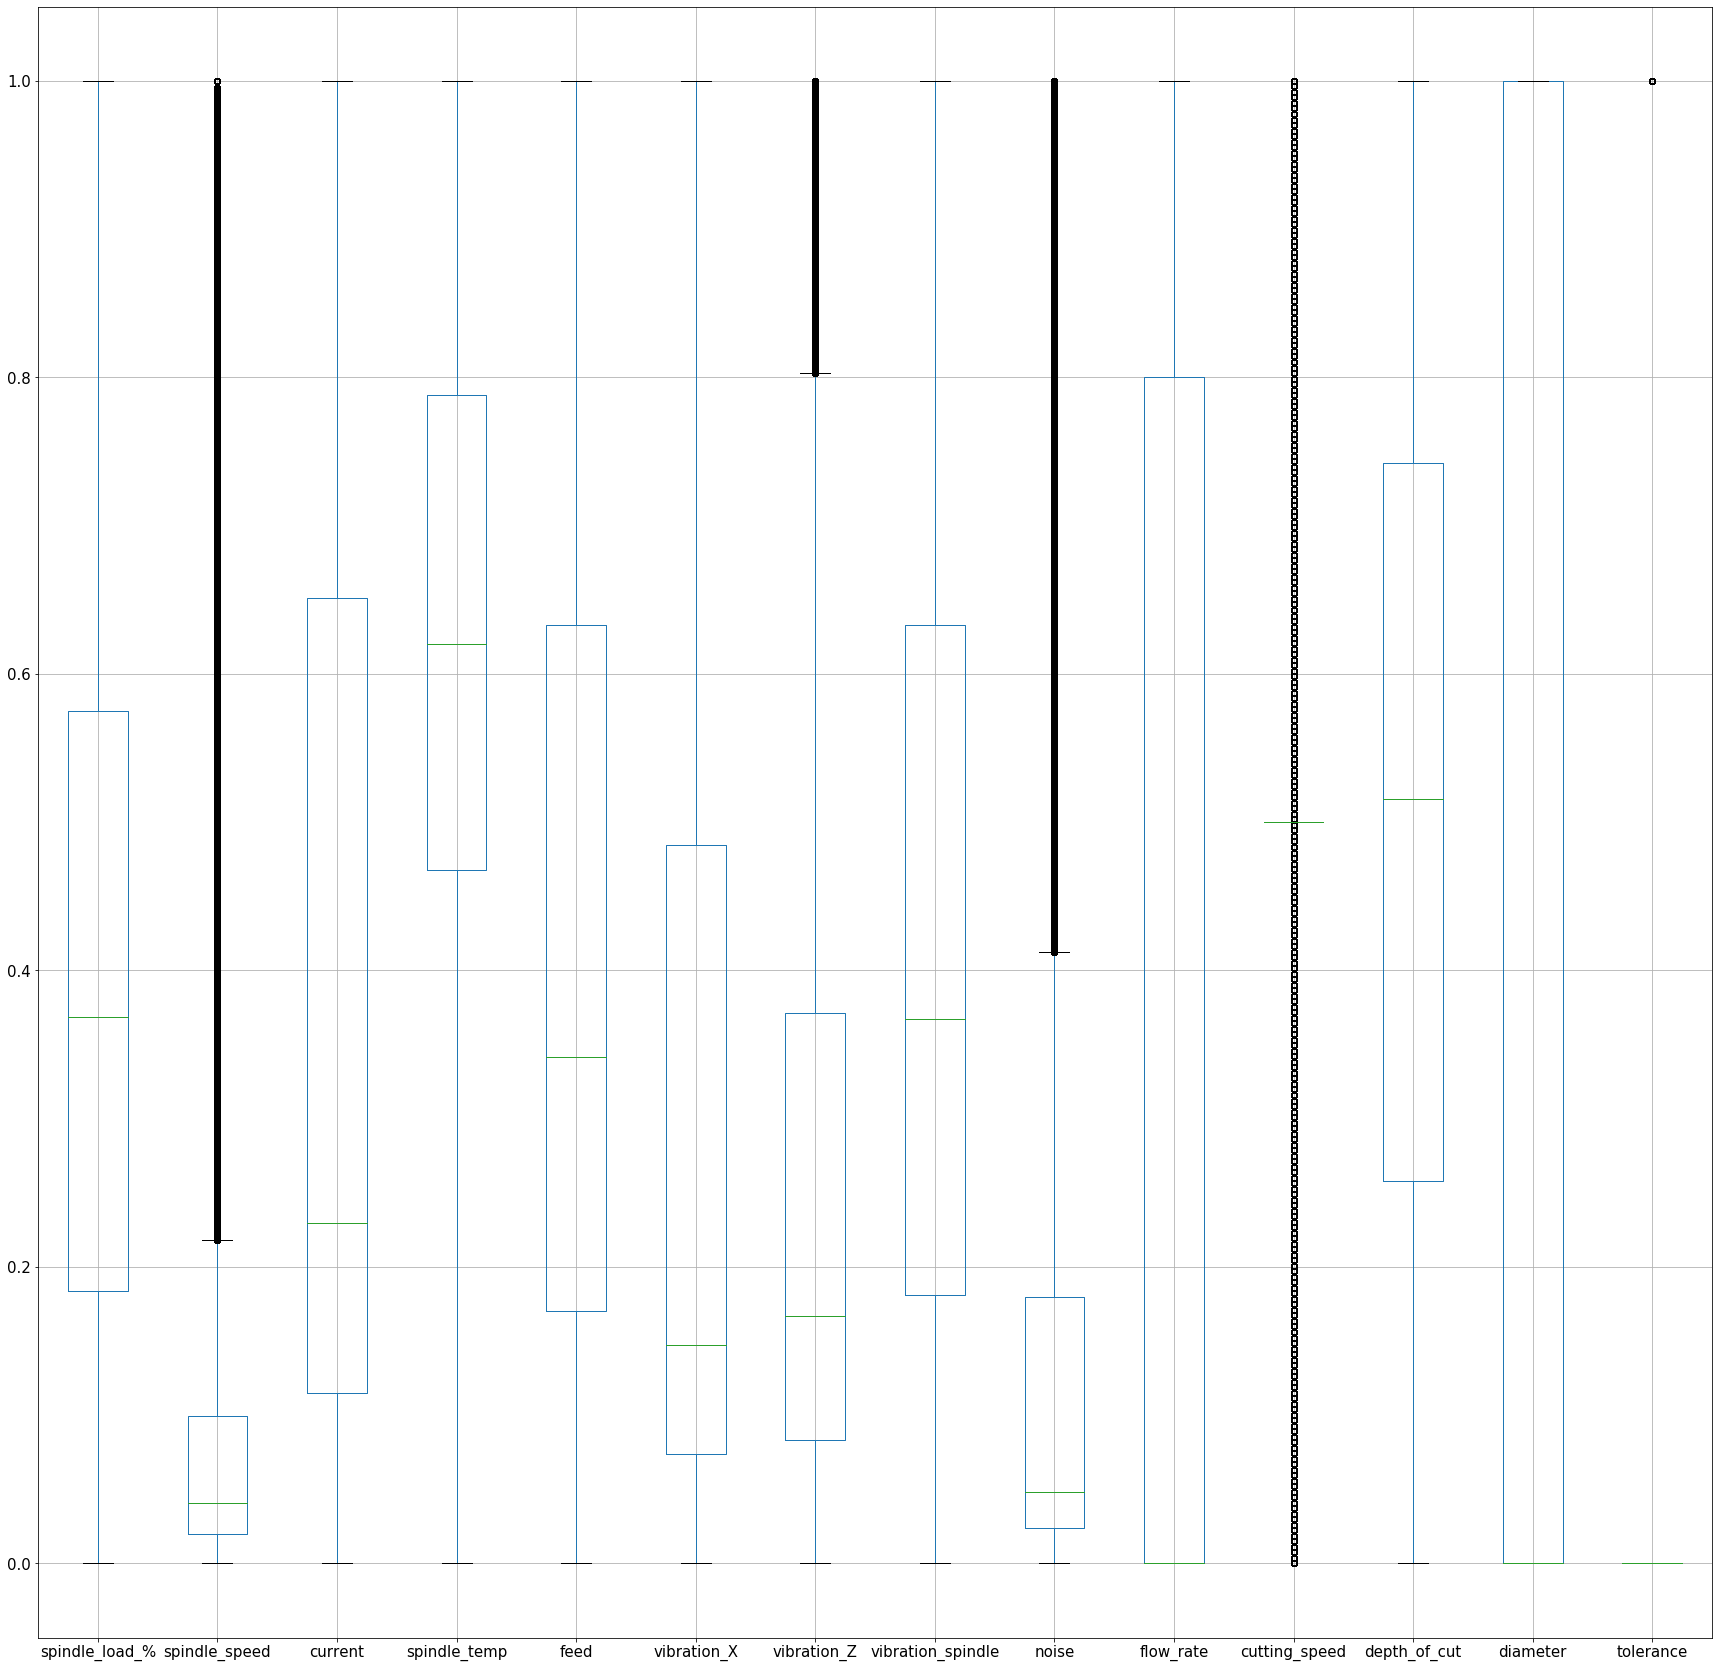

In [2]:
### Approx 100 machines and 1 day data

    
class AnomalyDetection:

### INITIATOR ###

    def __init__(self):
        # ! pip install pymongo
        # try:
          # import pymongo
          # from pymongo import MongoClient
          # import json
        # except Exception as e:
        #   print("Some modules are missing")
        pass



## TO IMPORT THE DATA FROM MONGODB SERVER AS PANDAS DATAFRAME


    def loadData (self):
        client = MongoClient()
        db = client.DataIntern
        collection = db.AnomalyDetect
        dataStored = pd.DataFrame(list(collection.find()))
        dataStored=dataStored.iloc[:,1:]
        dataStored['part_cycle_time']=pd.to_datetime(dataStored['part_cycle_time'])
        return dataStored


### TO MAKE SOME CHANGES IN SOME PARTICULAR COLUMNS ###

    # def columnManipulation(self,df):
        #   ## To correct the values of certain columns
        #   import numpy as np
        #   import itertools
        #   np.random.seed(1)
        #   totalItem=1000
        #   randomNum1=np.random.randint(60,1800,totalItem)
        #   randomList=list(randomNum1)
        #   # to generate 1000 evenly spaced numbers between 1 and 1000
        #   ranList1=np.linspace(1,totalItem,totalItem,dtype="int")
        #   ranList2=np.random.randint(1,200,totalItem)
        #   #print(ranList2)
        #   # to make the part_count and part_ID column 
        #   lis=[]
        #   lis1=[]
        #   for i in range(len(randomList)):
        #       lis.append(np.repeat(ranList1[i],randomList[i]))
        #       lis1.append(np.repeat(ranList2[i],randomList[i]))
        #   df['part_count']=list(itertools.chain.from_iterable(lis))
        #   df['part_ID']=list(itertools.chain.from_iterable(lis1))  
        #   return df

  
    ### TO IMPUTE USING KNN IMPUTER BUT DID NOT USE ###

    # def knnImpute(self,df,column):
        #   import numpy as np
        #   from sklearn.impute import KNNImputer
        #   x=df[column].values
        #   imputer= KNNImputer(n_neighbors=2)
        #   print("\n")
        #   print("The result after KNN Imputation")
        #   print(imputer.fit_transform(x.reshape(-1,1)))
        #   print("\n")


### FOR MAKING SOME CHANGES IN SOME OF THE COLUMNS IN THE DATA ###

    def dataManipulation(self):
        ## To remove the unneccessary columns and to store a copy of the dataframe
        ## To create only time and time_in_second column
        #print(data['_id'].nunique())
        data=self.loadData()
        df1=data
        df=data
        df['part_cycle_time']=df1['part_cycle_time'].dt.time
        data1=self.loadData()
        data2=self.loadData()
        data3=self.loadData()

        d=((data1['part_cycle_time'].dt.minute)*60)+data2['part_cycle_time'].dt.second
        df.insert(1, 'time_in_second', d)
        df.insert(2,'cumsum_in_minute',((df['time_in_second'].cumsum())/60).astype(int))
        df.insert(3,'cumsum_in_hour',((df['time_in_second'].cumsum())/3600).astype(int))
        df.insert(1,'time_in_minute',data2['part_cycle_time'].dt.minute)
        df.insert(0,'part_cycle_time_with_date',data3['part_cycle_time'])
        df['material'].replace({'MILD_STEEL':1},inplace=True)
        df['quality1']=df['quality']
        df.drop("quality",axis=1,inplace=True)
        df.rename(columns={"quality1":"quality"},inplace=True)
        df['running_tool_number'].fillna(0, inplace=True)
        df['tool_changed'].fillna(0,inplace=True)
        #self.knnImpute(df,'tolerance')
        df['tolerance'].fillna(df['tolerance'].mean(),inplace=True) 
        df['cutting_speed'].fillna(df['cutting_speed'].mean(),inplace=True)
        df['cutting_speed'].fillna(df['cutting_speed'].median(),inplace=True)
        # for i in range(len(l1)):
        #   comparison=l1[i]==l2[i]
        #   if (comparison == False):
        #     print(f"{l1[i]} and {l2[i]}")
        #     break
        return df


### FOR MAKING A NEW DATA AFTER DROPPING SOME OF THE COLUMNS ###

    def newData(self):
        df=self.dataManipulation()
        df_new=df
        df_new.drop(columns=['part_cycle_time','time_in_minute','time_in_second','cumsum_in_minute','part_ID','program_number'],inplace=True)
        df_new.drop(columns=['part_cycle_time_with_date','part_count','running_tool_number','tool_changed','material'],inplace=True)
        return df_new

        # def normalizedData(self):
        #   df=self.newData()
        #   d_var=df.drop(columns=['cumsum_in_hour','quality'])
        #   normalized_df=((d_var-d_var.min())/(d_var.max()-d_var.min()))
        #   return normalized_df

        ### TO NORMALIZE THE DATA USING MINMAX NORMALIZER FROM SKLEARN LIBRARY ###

    def normalizedData(self):
        df=self.newData()
        minmax = MinMaxScaler()
        for x in df.columns:
            if (x!='cumsum_in_hour' and x!='quality'):
                df[x] = minmax.fit_transform(np.array(df[x]).reshape(-1,1))
        #df.style.background_gradient(cmap='Blues')
        return df


    def dataDivPart(self):
        df=self.normalizedData()
        np.random.seed(1)
        totalItem=1000
        randomNum1=list(np.random.randint(60,1800,totalItem))
        #randomList=list(sum(randomNum1[0:x+1] for x in range (len(randomNum1))))
        randomList=[sum(randomNum1[0:x+1]) for x in range(0,len(randomNum1))]
        df_div=[]
        index=0
        for i,val in enumerate(randomList):
            df_div.append(df.iloc[index:val,:])
            index=val 
        return df_div


    def dataDivPartNew(self):
        df=self.normalizedData()
        df1=self.loadData()
        df.insert(0,'part_cycle_time',df1['part_cycle_time'])
        np.random.seed(1)
        totalItem=1000
        randomNum1=list(np.random.randint(60,1800,totalItem))
        #randomList=list(sum(randomNum1[0:x+1] for x in range (len(randomNum1))))
        randomList=[sum(randomNum1[0:x+1]) for x in range(0,len(randomNum1))]
        df_div_new=[]
        index=0
        for i,val in enumerate(randomList):
            df_div_new.append(df.iloc[index:val,:])
            index=val 
        return df_div_new



  
    


### TO GET SOME INFORMATION ABOUT THE VARIOUS COLUMNS IN THE DATA ###

    def dataExploration(self):
        ## To get the information about the various columns in the dataframe
        df=self.dataDivPartNew()[0]
        # print(df.info())
        # print("\n")
        # print(df.describe())
        # print("\n")
        print(df.columns)
        # print("\n")
        # print(df.shape)
        # print("\n")
        # print(df.describe().shape)
        # print("\n")
        # #df['part_ID'].value_counts()
        # print(df.isnull().sum())
        # print("\n")
        return df


### TO MAKE THE LINEPLOT ###

    def lineplot(self,z):
        df=self.normalizedData()
        df.set_index('cumsum_in_hour',inplace=True) 
        df.plot(subplots=True,linewidth=2.0,figsize=(30,30))
        plt.axis([0,z,0,1])
        plt.legend(loc="upper left")
        plt.figure()
        plt.show()
        print("\n")


    # def lineplot(self,a1,b1,c1,d1):
      #   import matplotlib.pyplot as plt
      #   import seaborn as sns
      #   df=self.dataManipulation()
      #   fig, axes = plt.subplots(3,1, figsize=(10,10),sharex=True)
      #   # plt.xlim(1,50000)
      #   # plt.ylim(1,100)
      #   for name, ax in zip([a1,b1,c1], axes):
      #     plt.plot(data=df, x=d1, y=name, ax=ax, linewidth=2.0)
      #     ax.set_title(name)
      #     plt.show()
      #   # Remove the automatic x-axis label from all but the bottom subplot
      #   if ax != axes[-1]:
      #       ax.set_xlabel('')
      #   print("\n")





    # def boxplot(self,a1,b1,c1,d1):
      #   import matplotlib.pyplot as plt
      #   import seaborn as sns
      #   df=self.dataManipulation()
      #   fig, axes = plt.subplots(3, 1, figsize=(100, 100), sharex=True)
      #   plt.xlim(1,50000)
      #   plt.ylim(1,100)
      #   for name, ax in zip([a1, b1, c1], axes):
      #     sns.boxplot(data=df, x=d1, y=name, ax=ax)
      #     ax.set_title(name)
      #   # Remove the automatic x-axis label from all but the bottom subplot
      #   if ax != axes[-1]:
      #       ax.set_xlabel('')
      #   print("\n")


### TO MAKE THE BOXPLOT ###

    def boxgraph(self):
        df=self.normalizedData()
        df.set_index('cumsum_in_hour',inplace=True)
        # fig, axes = plt.subplots(3, 1, figsize=(100, 100), sharex=True)
        # plt.xlim(1,50000)
        # plt.ylim(1,100)
        # for name, ax in zip([a1, b1, c1], axes):
        df.boxplot(figsize=(30,30),fontsize=15,grid=True)
        plt.show()

        # Remove the automatic x-axis label from all but the bottom subplot
        # if ax != axes[-1]:
        #     ax.set_xlabel('')
        print("\n")


#### Observations from a box plot 
### Outliers are data points observed outside the whisker at a certain range   [Q1-1.5*IQR and Q3+1.5*IQR] IQR-> Inter-Quartile Range    (observed in spindle speed, noise, vibration_z and cutting speed)
### If the 50 percentile line is not in the middle then the data does not come from a symmetric distributrion
### 50 percentile line is closer to the Q1 line it is right-skewed as is oberved in many cases
### more the length more the inter-quartile range more is the spread of the distribution


### TO MAKE THE HISTOGRAM ###

    def histogram(self):
        df=self.normalizedData()
        plt.figure(figsize=(20,20))
        df.set_index('cumsum_in_hour',inplace=True)
        df.hist(grid=True,bins=15,color='steelblue', edgecolor='black', linewidth=2.0,
               xlabelsize=10, ylabelsize=10)
        plt.tight_layout(rect=(0, 0, 1.2, 1.2)) 
        # plt.tick_params(axis='x',labelsize=10)
        # plt.tick_params(axis='y',labelsize=10)
        plt.show()


### TO GET THE PEARSON AND SPEARMAN RANK CORRELATION COEFFICIENT ###
    def correlationCoefficient(self):
        df=self.normalizedData()
        df.set_index("cumsum_in_hour",inplace=True)
        corr=df.corr(method='pearson',min_periods=1)
        corr1=df.corr(method='spearman',min_periods=1)
        return corr,corr1


# Correlation Matrix Heatmap
    def correlationHeatMap(self):
        df=self.normalizedData()
        df.set_index("cumsum_in_hour",inplace=True)
        f, ax = plt.subplots(figsize=(10, 6))
        corr = df.corr(method="pearson")
        sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                        linewidths=.05)
        f.subplots_adjust(top=0.93)
        f.suptitle('Pearson Correlation Heatmap', fontsize=14)


### TO GET THE HEAT MAP BUT COULD NOT USE IT AS IT COULD A LOT OF TIME ###

    def heatmap(self):
        df=self.normalizedData()
        df.set_index("cumsum_in_hour",inplace=True)
        df.drop(columns=['quality'],inplace=True)
        sns.heatmap(df,annot=True,cmap='RdYlGn', linewidths=0.5)

### TO GET THE DISTRIBUTION PLOT BUT COULD NOT USE IT AS IT COULD A LOT OF TIME ###

    def distplot(self,x):
        df=self.normalizedData()
        sns.distplot(df[x])
        #sns.kdeplot(df[x], shade=True, color='steelblue')
    

# Pair-wise Scatter Plots

    def pairwiseScatter(self):
        df=self.normalizedData()

        cols = ['spindle_load_%', 'current', 'spindle_speed',
            'spindle_temp', 'feed', 'vibration_X', 'vibration_Z',
            'vibration_spindle', 'flow_rate', 'noise','cutting_speed',
            'depth_of_cut', 'diameter', 'tolerance']
        #f, ax = plt.subplots(figsize=(10, 6))
        sns.pairplot(df[cols], height=1.8, aspect=1.8,
                          plot_kws=dict(edgecolor="k", linewidth=0.5),
                          diag_kind="kde", diag_kws=dict(shade=True))


        # f.subplots_adjust(top=0.93, wspace=0.3)
        # f.suptitle('Pairwise Plots', fontsize=14)




# https://adtk.readthedocs.io/en/stable/quickstart.html

    def adtk(self,i):
        df=self.dataDivPartNew()
        df[i].drop(columns=['cumsum_in_hour','quality'],inplace=True)
        df[i].set_index("part_cycle_time",inplace=True)
        # series=validate_series(df[i])
        # plot(series)

        seasonal_ad = SeasonalAD()
        anomalies = seasonal_ad.fit_detect(df[i])
        plot(s_train, anomaly=anomalies, anomaly_color="red", anomaly_tag="marker")


############## k-means algorithm ##################################
###################################################################

# k-means is a widely used clustering algorithm. 
# It creates ‘k’ similar clusters of data points. 
# Data instances that fall outside of these groups 
# could potentially be marked as anomalies. 
# Before we start k-means clustering, 
# we use elbow method to determine the optimal number of clusters.
# Reference: https://towardsdatascience.com/time-series-of-price-anomaly-detection-13586cd5ff46

    def elbowplot(self):
        df=self.normalizedData()
        data = df[['spindle_load_%', 'current', 
           'spindle_temp', 'feed', 'vibration_X', 'vibration_Z',
           'vibration_spindle', 'flow_rate', 
           'depth_of_cut', 'diameter', 'tolerance']]
        n_cluster = range(1, 20)
        kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
        scores = [kmeans[i].score(data) for i in range(len(kmeans))]

        fig, ax = plt.subplots(figsize=(10,6))
        ax.plot(n_cluster, scores)
        plt.xlabel('Number of Clusters')
        plt.ylabel('Score')
        plt.title('Elbow Curve')
        plt.show()


## from the elbow plot it can be seen that the plot levels off after 15 so here n_cluster=15

    def kmeans(self):
        df=self.normalizedData()
        X = df[['spindle_load_%', 'current', 'spindle_speed',
            'spindle_temp', 'feed', 'vibration_X', 'vibration_Z',
            'vibration_spindle', 'flow_rate', 'noise',
            'depth_of_cut', 'diameter', 'tolerance']]
        #X = X.reset_index(drop=True)
        km = KMeans(n_clusters=15)
        km.fit(X)
        km.predict(X)
        labels = km.labels_
        print(labels)
        print(km.get_params)
        #Plotting
        # fig = plt.figure(1, figsize=(30,30))
        # ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)
        # ax.scatter(X.iloc[:,0], X.iloc[:,4], X.iloc[:,3],
        #           c=labels.astype(np.float), edgecolor="k")
        # plt.title("K Means", fontsize=14)
        plt.scatter(X.iloc[:, 0], X.iloc[:, 3])


# Now we need to find out the number of components (features) to keep

    def pca(self):
        df=self.normalizedData()
        data = df[['spindle_load_%', 'current', 'spindle_speed',
           'spindle_temp', 'feed', 'vibration_X', 'vibration_Z',
           'vibration_spindle', 'noise', 'flow_rate', 'cutting_speed',
           'depth_of_cut', 'diameter', 'tolerance']]
        X = data.values
        X_std = StandardScaler().fit_transform(X)
        mean_vec = np.mean(X_std, axis=0)
        cov_mat = np.cov(X_std.T)
        eig_vals, eig_vecs = np.linalg.eig(cov_mat)
        eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]
        eig_pairs.sort(key = lambda x: x[0], reverse= True)
        tot = sum(eig_vals)
        var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] # Individual explained variance
        cum_var_exp = np.cumsum(var_exp) # Cumulative explained variance
        plt.figure(figsize=(10, 5))
        plt.bar(range(len(var_exp)), var_exp, alpha=0.3, align='center', label='individual explained variance', color = 'g')
        plt.step(range(len(cum_var_exp)), cum_var_exp, where='mid',label='cumulative explained variance')
        plt.ylabel('Explained variance ratio')
        plt.xlabel('Principal components')
        plt.legend(loc='best')
        plt.show()


    def pca1(self):

        # Take useful feature and standardize them
        data = df[['spindle_load_%', 'current', 'spindle_speed',
              'spindle_temp', 'feed', 'vibration_X', 'vibration_Z',
              'vibration_spindle', 'noise', 'flow_rate', 'cutting_speed',
              'depth_of_cut', 'diameter', 'tolerance']]
        X = data.values
        X_std = StandardScaler().fit_transform(X)
        data = pd.DataFrame(X_std)
        # reduce to 2 important features
        pca = PCA(n_components=15)
        data = pca.fit_transform(data)
        # standardize these 2 new features
        scaler = StandardScaler()
        np_scaled = scaler.fit_transform(data)
        data = pd.DataFrame(np_scaled)


# To get the count of the Accepted and Rejected parts
    def count(self):
        df=self.loadData()
        df['quality'].replace({"ACCEPTED":1,"REJECTED":0},inplace=True)
        df['quality'].dropna(inplace=True)
        #print(df['quality'].isnull().sum())
        neg, pos = np.bincount(df['quality'])
        total = neg + pos
        print('Examples:\n    Total: {}\n    Negative: {} ({:.2f}% of total)\n'.format(
            total, neg, 100 * neg / total))


# The whole dataframe was divided into train, test and validation set
# The validataion set is used during the model fitting to evaluate the loss and any metrics. 
# The test set is completely unused during the training phase and is only used at the end to evaluate 
# how well the model is performing on unseen data.
# This is especially important in case of imbalanced data where overfitting is a significant concern. 


    def trainTestSplit(self):
        df=self.dataDivPart()
        for i in range(len(df)):
            df[i]['quality'].replace({"ACCEPTED":1,"REJECTED":0},inplace=True)
            df[i]['quality'].dropna(inplace=True)

        train, test = train_test_split(df, test_size=0.2)
        train, val = train_test_split(train, test_size=0.2)

        # print(len(train), 'train examples')
        # print(len(val), 'validation examples')
        # print(len(test), 'test examples')
        return train,val,test

# Form np arrays of labels and features.
    # def train_labels_features(self):
      #   train,val,test=self.trainTestSplit()
      #   train1=train[:210]
      #   train2=train[210:420]
      #   train3=train[420:]
      #   def div(train):
      #     train_labels_list=[]
      #     train_features_list=[]
      #     train_list=[]
      #     for i in range(len(train)):
      #       train_labels_list.append(train[i].loc[:,'quality'].values.tolist())
      #       train[i].drop(columns=['quality'],inplace=True)
      #       #train_features_list.append(train[i].values)
      #       for elem in train[i].values:
      #         for item in elem:
      #           train_list.append(item)
      #           print(train_list)

      #       train_features_list.append(train_list)
      #       print(train_features_list)

      #     train_labels=[item for elem in train_labels_list for item in elem ]
      #     return train_labels,train_features_list


      #   train_labels1,train_features1=div(train1)
      #   train_labels2,train_features2=div(train2)
      #   train_labels3,train_features3=div(train3)
      #   train_labels=train_labels1+train_labels2+train_labels3
      #   train_features=train_features1+train_features2+train_features3

      #   train_labels=np.array(train_labels)
      #   train_features=np.array(train_features)
      #   # print("\n The train labels are\n")
      #   print(len(train_labels))
      #   # print("\n The train features are\n")
      #   print(len(train_features))


      #   return train_labels,train_features



# Form np arrays of labels and features.
    def train_labels_features(self):
        train,val,test=self.trainTestSplit()
        train_labels_list=[]
        train_features_list=[]
        train_list=[]


        for i in range(len(train)):
            train_labels_list.append(train[i].loc[:,'quality'].values.tolist())
            train[i].drop(columns=['quality'],inplace=True)
            train_features_list.append(train[i].values.tolist())
        train_labels=[item for elem in train_labels_list for item in elem]
        train_labels=np.array(train_labels)
        #train_features=np.array(train_features_list)
        # print("\n The train labels are\n")
        #print(len(train_labels))
        # print("\n The train features are\n")
        return train_features_list



    def val_labels_features(self):
        train,val,test=self.trainTestSplit()
        val_labels_list=[]
        val_features_list=[]
        val_list=[]
        len_val=[]
        for i in range(len(val)):
            
            
            val_labels_list.append(val[i].loc[:,'quality'].values.tolist())
            val[i].drop(columns=['quality'],inplace=True)
            for elem in val[i].values:
                for item in elem:
                    val_list.append(item)

            val_features_list.append(val_list)
            len_val.append(len(val_features_list[i]))
        val_features=np.array(val_features_list)
        val_labels=[item for elem in val_labels_list for item in elem ]
        val_labels=np.array(val_labels)
        #print("\n The val labels are\n")
        #print(len(val_labels))
        # print("\n The val features are\n")
        # print(val_features)
        print(len(len_val))
        print("\n")
        print(len_val)

        return val_labels,val_features



    def test_labels_features(self):
        train,val,test=self.trainTestSplit()
        test_labels_list=[]
        test_features_list=[]
        test_list=[]
        len_test=[]
        for i in range(len(test)):
            
            test_labels_list.append(test[i].loc[:,'quality'].values.tolist())
            test[i].drop(columns=['quality'],inplace=True)
            for elem in test[i].values:
                for item in elem:
                    test_list.append(item)

            test_features_list.append(test_list)
            len_test.append(len(test_features_list[i]))
        test_features=np.array(test_features_list)
        test_labels=[item for elem in test_labels_list for item in elem ]
        test_labels=np.array(test_labels)
        # print("\n The test labels are\n")
        # print(len(test_labels))
        # print("\n The test features are\n")
        # print(test_features)
        print(len(len_test))
        print("\n")
        print(len_test)

        return test_labels,test_features
    
    
    


#### MAIN FUNCTION ######

def main():
    a=AnomalyDetection()
    #print(a.loadData())
    # print("\n")
    #print(a.dataManipulation())
    # print("\n")
    #print(a.newData().shape)
    #a.dataExploration()
    # print("\n")
    #print(a.normalizedData())
    #df.style.background_gradient(cmap='Blues')


    #a.lineplot(4000)
    #print("\n")
    #a.lineplot('spindle_speed','cumsum_in_hour',1500)
    a.boxgraph()
    #print("\n")
    #a.heatmap()
    # print("The pearson coefficient is:")
    # print(a.correlationCoefficient()[0])
    # print("\n")
    # print("The spearman coefficient is:")
    # print(a.correlationCoefficient()[1])
    #a.histogram()
    #a.distplot("spindle_speed")
    #a.elbowplot()
    #a.kmeans()
    # a.correlationHeatMap()
    # a.pairwiseScatter()
    #a.pca()
    # a.dataDivPart()
    #a.adtk(700)
    #print(a.dataDivPartNew())
    # a.trainTestSplit()
    # print("\n")
    # a.count()
    #train_features=a.train_labels_features()
    #output=[]
    # def reemovNestings(l): 

    #   for i in l:
    #     if type(i) == list:
    #       reemovNestings(i) 
    #     else:
    #       output.append(i)
    #   return output

    # print(reemovNestings(train_features))



#     import functools
#     import operator
#     for i in range(len(train_features)):
#         List_flat = functools.reduce(operator.iconcat, train_features[i],[])
#         output.append(List_flat)


#     print("Flattened List:\n",output)


  #a.val_labels_features()
  #a.test_labels_features()


if __name__=="__main__":
    main()
